In [1]:
import sys
import os
import pandas as pd
import yaml
import numpy as np

# Set the base directory 
base_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
os.chdir(base_dir) # to be able to find ./config/myfile.yaml

# Add base directory to the Python path for imports
sys.path.append(base_dir)

from bin import generate_stream



# Stream Search Analysis Using `stream_sim`

In this notebook, we will explore the functionality of the `stream_sim` package in the context of stream search analysis. This comprehensive guide includes several key components:

1. **Stream Generation**:  generating a stellar stream based on a predefined configuration file.

2. **Survey Application**: application of a selected survey to the stars within the generated stream.

3. **Catalog Injection**: injection of the stars into a synthetic catalog.

4. **Stream Detection**: employing a specified algorithm to search for the injected stream within the catalog.


# Generation of a stream

This section needs configuration files to generate streams.

In [2]:
# Path to the YAML config file in the 'config' folder
config_file = 'toy1_config.yaml'
config_file = 'pal5_config.yaml'
config_path = os.path.join(base_dir, 'config', config_file)

# Load YAML and convert it to a DataFrame
with open(config_path, 'r') as file:
    config_data = yaml.safe_load(file)

df = pd.DataFrame(config_data)
df.head()

,stream,background
filename,./data/erkal_2016_pal_5_input.csv,NaN
nstars,115000.0,100000.0
density,"{'type': 'FileInterpolation', 'filename': './d...","{'type': 'Uniform', 'xmin': -10.0, 'xmax': 18.0}"
track,"{'center': {'type': 'FileInterpolation', 'file...","{'center': {'type': 'Constant', 'value': 0.0},..."
isochrone,"{'name': 'Bressan2012', 'survey': 'lsst', 'age...",NaN


In [3]:
stream = generate_stream.generate_stream(config_data)

Generating stream...
  generated 115000 stream stars.
Generating background...
  generated 100000 background stars.
Combining stream and background.


/sps/lsst/users/mpelissi/packages/stream_sim/bin/generate_stream.py:44: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  out = pd.concat([stream_df, bkg_df])


Text(0, 0.5, '$\\phi_2$ (deg)')

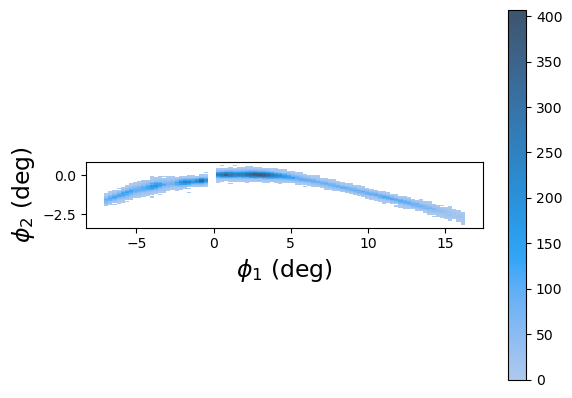

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
fig,ax = plt.subplots(1,1)
streamstars = stream[stream['flag']==1]
sns.histplot(x=streamstars['phi1'],y=streamstars['phi2'],cbar=True)
plt.axis('scaled')
ax.set_xlabel(r'$\phi_1$ (deg)',fontsize=17)
ax.set_ylabel(r'$\phi_2$ (deg)',fontsize=17)

In [5]:
stream[stream['flag']==1].describe()

,phi1,phi2,dist,mag_g,mag_r,flag
count,115000.000000,115000.000000,115000.000000,115000.000000,115000.000000,115000.0
mean,2.361758,-0.511845,16.736176,27.448894,26.352832,1.0
std,5.416193,0.652247,0.541619,2.490011,2.149267,0.0
min,-7.099999,-3.179462,15.790085,14.738196,13.749452,1.0
25%,-1.646092,-0.889044,16.335373,26.085831,25.157927,1.0
50%,2.149689,-0.331668,16.714999,27.602294,26.501881,1.0
75%,4.927260,0.004203,16.992732,29.106835,27.789557,1.0
max,16.280000,0.689958,18.128032,33.927753,32.080883,1.0


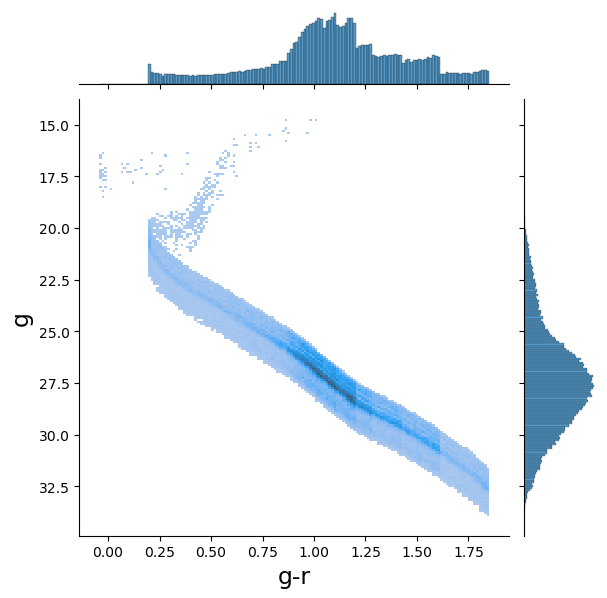

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Example data (use your actual dataframe's columns instead)
x = stream["mag_g"] - stream["mag_r"]
y = stream["mag_g"]

# select only stars with magnitudes
mask = (np.isfinite(x))&(np.isfinite(y))
x,y = x[mask], y[mask]

fontsize = 17

# Function for Seaborn plotting
def seaborn_plot(x, y):
    import seaborn as sns
    sns.jointplot(x=stream["mag_g"]-stream["mag_r"], y=stream["mag_g"], kind="hist")
    plt.xlabel("g-r", fontsize=fontsize)
    plt.ylabel("g", fontsize=fontsize)
    plt.gca().invert_yaxis()
    plt.show()

# Function for Matplotlib plotting
def matplotlib_plot(x, y):
    # Create a grid for the 2D histogram and marginal histograms
    fig = plt.figure(figsize=(8, 8))

    # Define grid positions
    gs = fig.add_gridspec(4, 4)
    ax_main = fig.add_subplot(gs[1:4, 0:3])  # 2D histogram in main grid
    ax_hist_x = fig.add_subplot(gs[0, 0:3], sharex=ax_main)  # Histogram for x (top)
    ax_hist_y = fig.add_subplot(gs[1:4, 3], sharey=ax_main)  # Histogram for y (right)

    # 2D histogram
    hist = ax_main.hist2d(x, y, bins=100, cmap='Blues')  # Adjust bins and colormap as needed
    ax_main.set_xlabel("g-r", fontsize=fontsize)
    ax_main.set_ylabel("g", fontsize=fontsize)
    ax_main.invert_yaxis()

    # Add a colorbar for the 2D histogram
    plt.colorbar(hist[3], ax=ax_main)

    # Histogram for x (g-r)
    ax_hist_x.hist(x, bins=100, alpha=0.6, color='gray')
    ax_hist_x.axis('off')  # Hide ticks and labels for cleaner look

    # Histogram for y (g)
    ax_hist_y.hist(y, bins=100, orientation='horizontal', alpha=0.6, color='gray')
    ax_hist_y.axis('off')  # Hide ticks and labels for cleaner look

    # Synchronize limits for better alignment
    ax_hist_x.set_xlim(ax_main.get_xlim())
    ax_hist_y.set_ylim(ax_main.get_ylim())

    # Adjust layout for spacing
    plt.subplots_adjust(hspace=0.05, wspace=0.05)

    plt.show()

# Check if Seaborn is installed and call the appropriate plotting function
try:
    import seaborn
    seaborn_plot(x, y)
except ImportError:
    matplotlib_plot(x, y)

# Apply the survey properties
This section needs the `observed.py` module into *stream_sim*.
To inject in in a survey, it also needs a configuration file of the survey, pointing to the following files:

- maglim_map_g: supreme_dc2_dr6d_v3_g_maglim_psf_wmean.fits.gz
- maglim_map_r: supreme_dc2_dr6d_v3_r_maglim_psf_wmean.fits.gz
- ebv_map: ebv_sfd98_fullres_nside_4096_ring_equatorial.fits
- completeness: stellar_efficiency_truth.csv
- log_photo_error: photoerror_r.csv
- coverage: supreme_dc2_dr6d_v3_gr_fracdet.fits.gz


and the following properties:
- coeff_extinc_g: 3.237
- coeff_extinc_r: 2.273
- sys_error : 0.005

Here the values and names are specified in the example of LSST.

In [7]:
from stream_sim import observed

# Load the survey properties
obj = observed.StreamObserved(survey='LSST_DC2')

###################### Reading Survey property files ######################
Survey's files are searched at the following path :  /sps/lsst/users/mpelissi/packages/stream_sim/stream_sim/../data/surveys/LSST_DC2
Reading maglim map g: /sps/lsst/users/mpelissi/packages/stream_sim/stream_sim/../data/surveys/LSST_DC2/supreme_dc2_dr6d_v3_g_maglim_psf_wmean.fits.gz...
Reading maglim map r: /sps/lsst/users/mpelissi/packages/stream_sim/stream_sim/../data/surveys/LSST_DC2/supreme_dc2_dr6d_v3_r_maglim_psf_wmean.fits.gz...
Reading ebv map: /sps/lsst/users/mpelissi/packages/stream_sim/stream_sim/../data/surveys/LSST_DC2/ebv_sfd98_fullres_nside_4096_ring_equatorial.fits...
Reading completeness: /sps/lsst/users/mpelissi/packages/stream_sim/stream_sim/../data/surveys/LSST_DC2/stellar_efficiency_truth.csv...
Reading log photo error: /sps/lsst/users/mpelissi/packages/stream_sim/stream_sim/../data/surveys/LSST_DC2/photoerror_r.csv...
Reading coverage: /sps/lsst/users/mpelissi/packages/stream_sim/stream_si

In [8]:
# Inject stream stars (here contained into stream), and get observationnal values.
obs_stream = obj.inject(stream)

Generating random endpoints...
Creating stream frame...


/pbs/home/m/mpelissi/.conda/envs/desc_env2/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


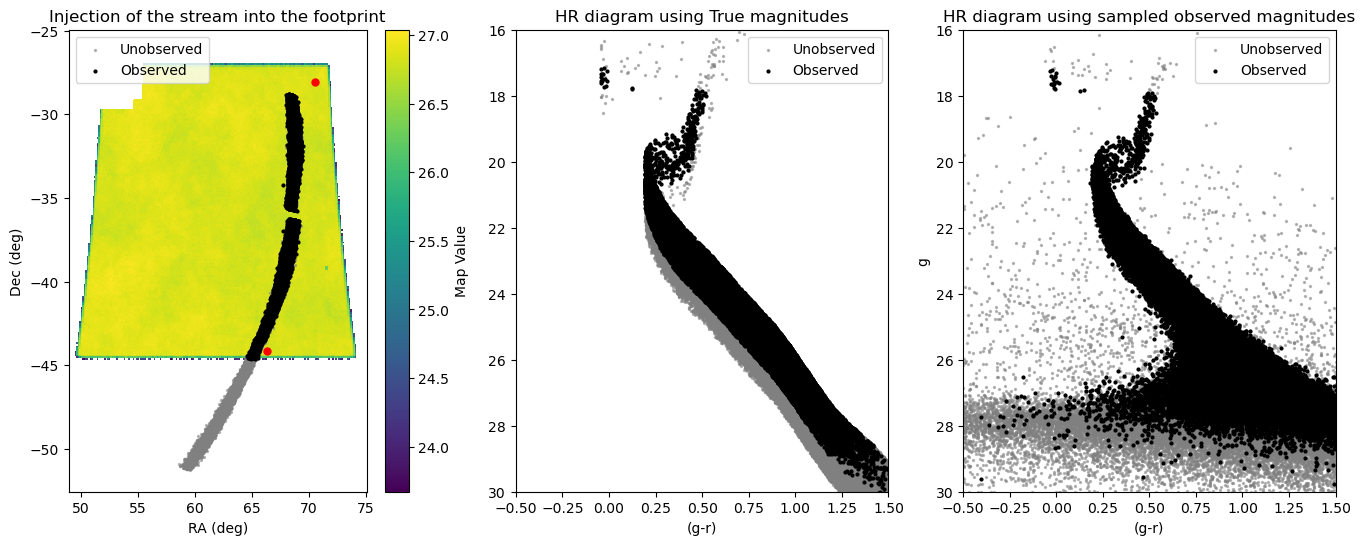

In [9]:
# Plot the result
obj.plot_inject(obs_stream)

# Inject the data into DC2
In this section we merge the data catalog of DC2 and the one of the stream's stars. It needs the module `healpy` and the following file :
- dp02_dc2_stars.fits : DC2 objects with  extendedness==0.


In [10]:
import astropy.io.fits as fits

# Open the FITS file
current_dir = (os.getcwd())
folder = os.path.join(current_dir, 'data/surveys/LSST_DC2')
filename = 'dp02_dc2_stars.fits'
full_path = os.path.join(folder, filename)
print('reading')
hdul = fits.open(full_path)

# Show the structure of the FITS file
hdul.info()

# Access the primary data (HDU - Header/Data Unit)
data_dc2 = hdul[1].data  # Usually, the table is in the second HDU (index 1)

print("It contains the following columns :",data_dc2.columns)


reading
Filename: /sps/lsst/users/mpelissi/packages/stream_sim/data/surveys/LSST_DC2/dp02_dc2_stars.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   ()      
  1                1 BinTableHDU     22   33084656R x 7C   [D, D, D, D, D, D, D]   
It contains the following columns : ColDefs(
    name = 'ra'; format = 'D'
    name = 'dec'; format = 'D'
    name = 'mag_g'; format = 'D'
    name = 'magerr_g'; format = 'D'
    name = 'mag_r'; format = 'D'
    name = 'magerr_r'; format = 'D'
    name = 'extendedness'; format = 'D'
)


In [11]:
df_dc2 = pd.DataFrame(data_dc2)

# Select only the detected stars
data_filtered = obs_stream[obs_stream['flag_detection'] == 1]

# select the chosen columns to merge and rename them if needed
data_filtered = data_filtered[['ra', 'dec',  'mag_g_meas', 'magerr_g', 'mag_r_meas', 'magerr_r']]
data_filtered = data_filtered.rename(columns={'mag_g_meas': 'mag_g', 'mag_r_meas': 'mag_r'}) 

# Store informations about the stars, that can be part of DC2 or a stream 
data_filtered['flag'] = 1 # stars of the stream named 1
df_dc2['flag'] = 'DC2'

df_tot = pd.concat([df_dc2, data_filtered], ignore_index=True)

In [12]:
print(np.min(data_dc2['extendedness']))

0.0


## Plot the results

### In the footprint

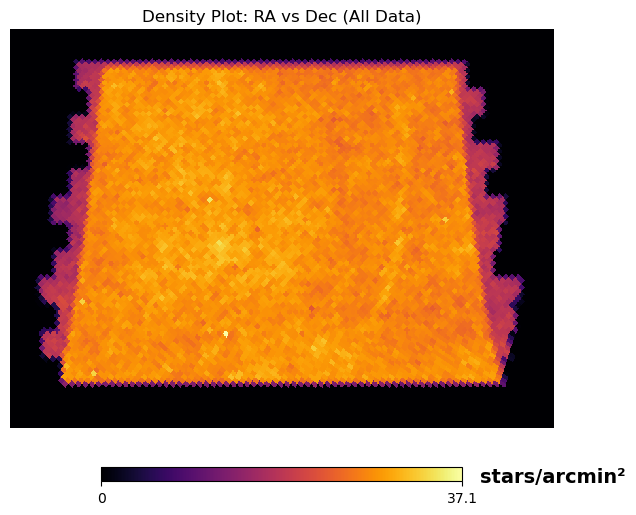

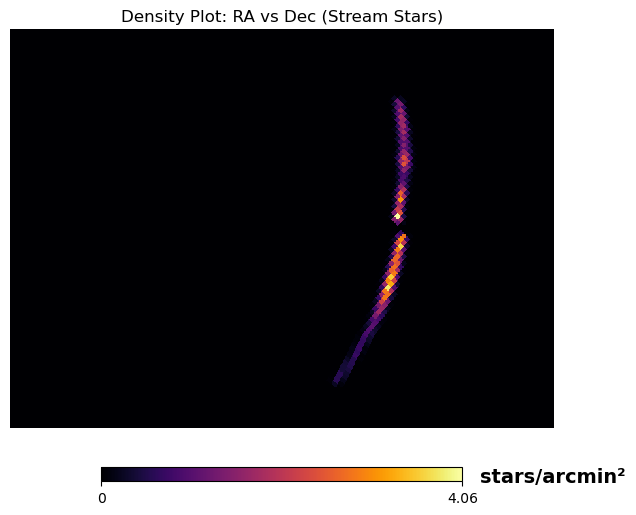

In [13]:
import healpy as hp

nside = 256  
npix = hp.nside2npix(nside)
pixarea = hp.nside2pixarea(nside, degrees=True) * 3600  # arcmin²

# Initialize Healpix maps
hpxmap_all = np.zeros(npix)
hpxmap_stream = np.zeros(npix)

# Convert RA, Dec to Healpix pixels
pixels_all = hp.ang2pix(nside, df_tot['ra'], df_tot['dec'], lonlat=True)
pixels_stream = hp.ang2pix(nside, df_tot['ra'][df_tot['flag'] == 1], df_tot['dec'][df_tot['flag'] == 1], lonlat=True)

# Count occurrences
pix, cts_all = np.unique(pixels_all, return_counts=True)
pix_stream, cts_stream = np.unique(pixels_stream, return_counts=True)

# Populate Healpix maps
hpxmap_all[pix] = cts_all / pixarea
hpxmap_stream[pix_stream] = cts_stream / pixarea


# Plot the density map for all data with flipped longitude
hp.cartview(hpxmap_all, lonra=[47, 77], latra=[-47, -25], unit='stars/arcmin²', cmap='inferno', 
            title='Density Plot: RA vs Dec (All Data)', flip='geo')

# Plot the density map for stream stars with flipped longitude
hp.cartview(hpxmap_stream, lonra=[47, 77], latra=[-47, -25], unit='stars/arcmin²', cmap='inferno', 
            title='Density Plot: RA vs Dec (Stream Stars)', flip='geo')

### In HR diagrams

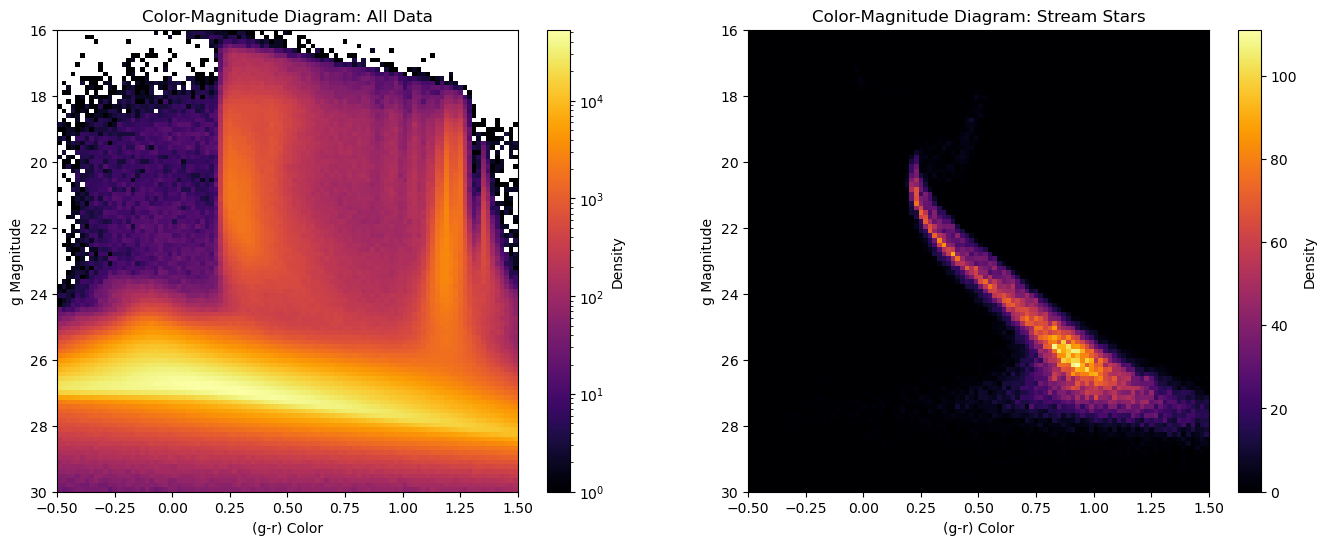

In [14]:
# Define ranges
x_range = (-0.5, 1.5)  # For (g-r) Color
y_range = (16, 30)     # For g Magnitude 

# Create 2D histograms for color-magnitude diagrams
hb_all, xedges, yedges = np.histogram2d(df_tot['mag_g'] - df_tot['mag_r'], df_tot['mag_g'], bins=[100, 100], range=[x_range, y_range])
hb_stream, xedges, yedges = np.histogram2d(df_tot['mag_g'][df_tot['flag'] == 1] - df_tot['mag_r'][df_tot['flag'] == 1], df_tot['mag_g'][df_tot['flag'] == 1], bins=[100, 100], range=[x_range, y_range])

# Plot the maps and histograms
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
plt.subplots_adjust(left=0.075, right=0.98)

# Plot the hexbin using the histograms
a=ax[0].imshow(hb_all.T, origin='lower', extent=[x_range[0], x_range[1], y_range[0], y_range[1]], cmap='inferno', aspect='auto',norm = 'log')
cb = plt.colorbar(a, ax=ax[0], label='Density')
ax[0].set_xlim(x_range)
ax[0].set_ylim(y_range[::-1])  # Invert y-axis for the plot
ax[0].set_xlabel('(g-r) Color')
ax[0].set_ylabel('g Magnitude')
ax[0].set_title('Color-Magnitude Diagram: All Data')

b=ax[1].imshow(hb_stream.T, origin='lower', extent=[x_range[0], x_range[1], y_range[0], y_range[1]], cmap='inferno', aspect='auto')
cb = plt.colorbar(b, ax=ax[1], label='Density')
ax[1].set_xlim(x_range)
ax[1].set_ylim(y_range[::-1])  # Invert y-axis for the plot
ax[1].set_xlabel('(g-r) Color')
ax[1].set_ylabel('g Magnitude')
ax[1].set_title('Color-Magnitude Diagram: Stream Stars')

plt.show()


# Find the stream using MatchFilter algorythm

From the merged dataframe of DC2 and the observed stream, we can try to find the stream using a match filter algorythm in HR diagram.
We set the filter from the same caracteristics used to generate the stream's isochrone.

Source of the code : [github](https://github.com/norashipp/stream_search)

In [15]:
from ugali.analysis.isochrone import factory as isochrone_factory
from matplotlib.path import Path


# Isochrone parameters                                                                                                                 
AGE = 12.
Z = 0.0006
DMU = 0.5
COLOR_SHIFT=[0.1,0.1]
ERROR_FACTOR=[5.0,1.0]
# Absolute magnitude of MSTO                                                                                                           
# WARNING: This is hardcoded                                                                                                           
MSTO = 3.5

def mkpol(mu, age=AGE, z=Z, dmu=DMU, C=COLOR_SHIFT, E=ERROR_FACTOR, err_type='median', rgb_clip=None):
    """Make the the isochrone matched-filter polygon.

    Parameters
    ----------
    mu : distance modulus
    age: isochrone age [Gyr]
    z  : isochrone metallicity [Z_sol]
    dmu: distance modulus spread
    C  : additive color spread
    E  : multiplicative error spread
    err: photometric error model; function that returns magerr as 
         a function of magnitude.
    survey: key to load error model
    clip: maximum absolute magnitude
    
    Returns
    -------
    verts : vertices of the polygon
    """
        
    """ Builds ordered polygon for masking """
    A1 = 0.0010908679647672335
    A2 = 27.091072029215375+2.5
    A3 = 1.0904624484538419
    err = lambda x: A1 + np.exp((x - A2) / A3) # median                                                                                
    iso = isochrone_factory('Dotter2008', age=age, z=z)
    c = iso.color
    m = iso.mag
    if rgb_clip is not None:
        rgb_mag = (MSTO-rgb_clip)
        print ("Clipping RGB at mag = %g"%rgb_mag)
        c = c[m > rgb_mag]
        m = m[m > rgb_mag]

    mnear = m + mu - dmu / 2.
    mfar = m + mu + dmu / 2.

    C0,C1 = C
    E0,E1 = E
    COL = np.r_[c + E1 * err(mfar) + C1, c[::-1] - E0 * err(mnear[::-1]) - C0]
    MAG = np.r_[m, m[::-1]] + mu
    return np.c_[COL, MAG]

def iso_sel(g, r, mu, age, z, dmu=DMU, color_shift=COLOR_SHIFT, error_factor=ERROR_FACTOR):
    """ Perform isochrone selection. """
    mk = mkpol(mu=mu, age=age, z=z, dmu=0.5, C=color_shift, E=error_factor)
    pth = Path(mk)
    cm = np.vstack([g - r, g]).T
    return pth.contains_points(cm)


def select_isochrone(mag_g, mag_r, err, iso_params=[17.0, 12.5, 0.0001], dmu=0.5,
                     C=[0.01, 0.01], E=2, gmin=None, survey='DECaLS'):
    """Create the isochrone matched-fitler polygon and select stars that
    reside within it.

    Parameters
    ----------
    mag_g, mag_r : measured magnitudes of the stars
    err: photometric error model; function that returns magerr as 
         a function of magnitude.
    iso_params : isochrone parameters [mu, age, Z]
    dmu: distance modulus spread
    C  : additive color spread
    E  : multiplicative error spread
    gmin : bright magnitude limit in g-band
    survey: key to load error model
    
    Returns
    -------
    selection : boolean array indicating if the object is in the polygon

    """
    mu, age, z = iso_params

    mk = mkpol(mu=mu, age=age, z=z, dmu=dmu, C=C, E=E, err=err, survey=survey)
    pth = Path(mk)
    cm = np.vstack([mag_g - mag_r, mag_g - mu]).T
    idx = pth.contains_points(cm)
    if gmin:
        idx &= (mag_g > gmin)
    return idx

In [16]:
# Generate the polynomial filter
output = mkpol(16.5, age=AGE, z=Z, dmu=DMU, C=COLOR_SHIFT, E=ERROR_FACTOR, err_type='median', rgb_clip=0.2) 

Clipping RGB at mag = 3.3


In [17]:
pth = Path(output)

df_sample =  df_tot # select the data you want to use for the selection, here all the data

cm = np.vstack([df_sample['mag_g'] - df_sample['mag_r'] , df_sample['mag_g'] ]).T

# Apply a cut on faintest objects AND select stars inside the matchfilter
cut_bottom = 25.5
flag = pth.contains_points(cm)&(df_sample['mag_g']<cut_bottom)

## Visualisation in HR diagram

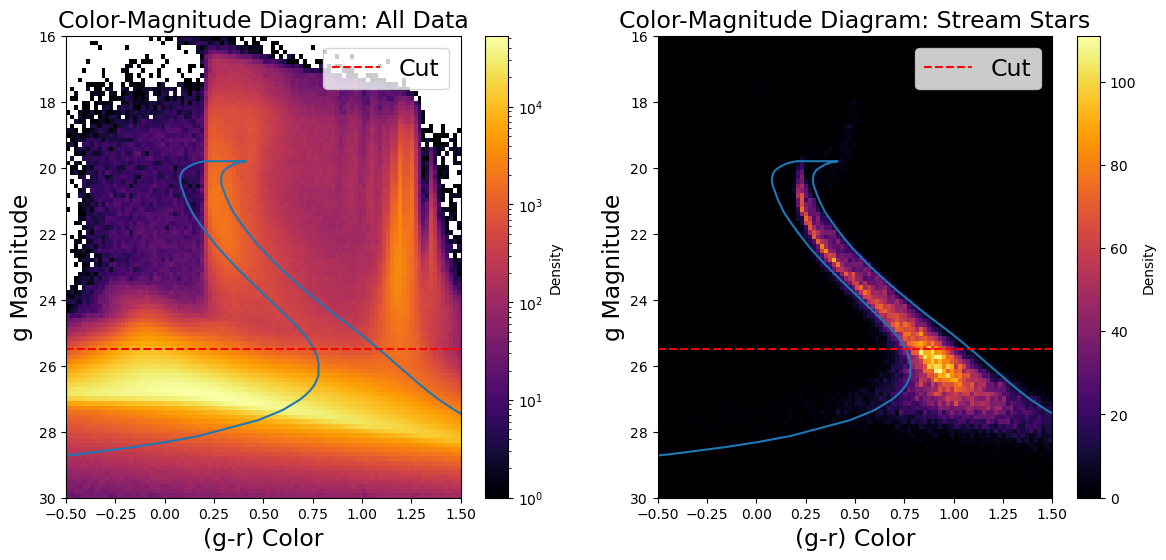

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

x_range = (-0.5, 1.5)  # For (g-r) Color
y_range = (16, 30)     # For g Magnitude 

hb_all, xedges, yedges = np.histogram2d(df_tot['mag_g'] - df_tot['mag_r'], df_tot['mag_g'], bins=[100, 100], range=[x_range, y_range])
hb_stream, xedges, yedges = np.histogram2d(df_tot['mag_g'][df_tot['flag'] == 1] - df_tot['mag_r'][df_tot['flag'] == 1], df_tot['mag_g'][df_tot['flag'] == 1], bins=[100, 100], range=[x_range, y_range])


a=ax[0].imshow(hb_all.T, origin='lower', extent=[x_range[0], x_range[1], y_range[0], y_range[1]], cmap='inferno', aspect='auto',norm = 'log')
cb = plt.colorbar(a, ax=ax[0], label='Density')
ax[0].plot(output[:,0],output[:,1])
ax[0].set_xlim(x_range)
ax[0].set_ylim(y_range[::-1])  # Invert y-axis for the plot
ax[0].set_xlabel('(g-r) Color',fontsize=fontsize)
ax[0].set_ylabel('g Magnitude',fontsize=fontsize)
ax[0].set_title('Color-Magnitude Diagram: All Data',fontsize=fontsize)
ax[0].axhline(cut_bottom,c='r',linestyle = '--',label='Cut')
ax[0].legend(fontsize=fontsize)



ax[1].imshow(hb_stream.T, origin='lower', extent=[x_range[0], x_range[1], y_range[0], y_range[1]], cmap='inferno', aspect='auto')
cb = plt.colorbar(ax[1].imshow(hb_stream.T, origin='lower', extent=[x_range[0], x_range[1], y_range[0], y_range[1]], cmap='inferno', aspect='auto'), ax=ax[1], label='Density')
ax[1].set_xlim(x_range)
ax[1].set_ylim(y_range[::-1])  # Invert y-axis for the plot
ax[1].set_xlabel('(g-r) Color',fontsize=fontsize)
ax[1].set_ylabel('g Magnitude',fontsize=fontsize)
ax[1].set_title('Color-Magnitude Diagram: Stream Stars',fontsize=fontsize)
ax[1].plot(output[:,0],output[:,1])
ax[1].axhline(cut_bottom,c='r',linestyle = '--',label='Cut')
ax[1].legend(fontsize=fontsize)

## Visualisation in sky

Text(0, 0.5, 'dec (deg)')

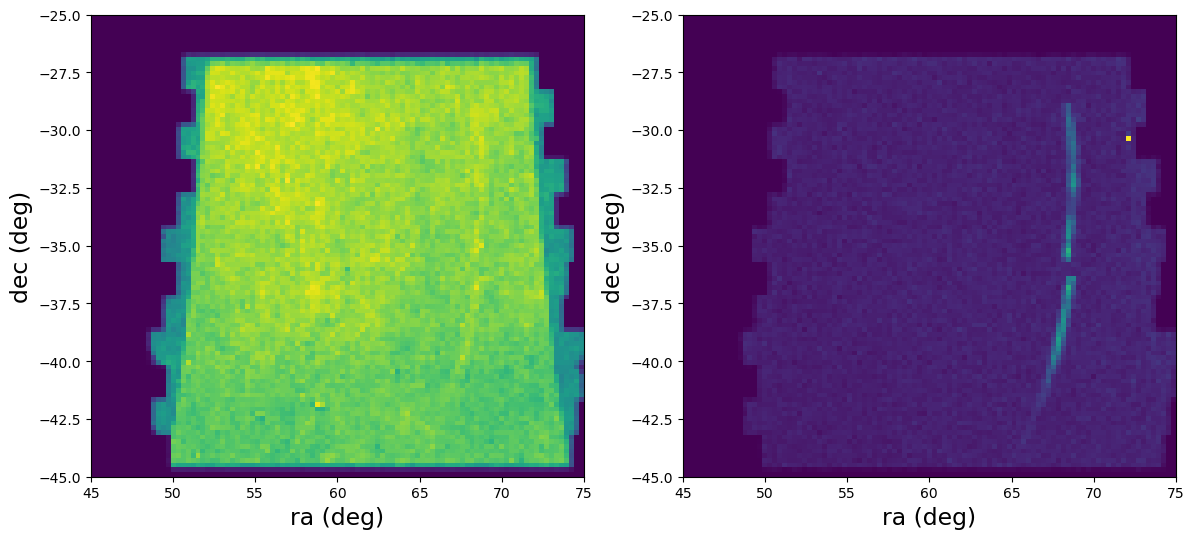

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
bins = [np.linspace(45,75,100),np.linspace(-45,-25,100)]

# All the data
ax[0].hist2d(df_sample['ra'],df_sample['dec'],bins=bins)

# Only selected stars
ax[1].hist2d(df_sample[flag]['ra'],df_sample[flag]['dec'],bins=bins)

ax[0].set_xlabel('ra (deg)',fontsize=fontsize)
ax[1].set_xlabel('ra (deg)',fontsize=fontsize)
ax[0].set_ylabel('dec (deg)',fontsize=fontsize)
ax[1].set_ylabel('dec (deg)',fontsize=fontsize)

## To generate a film
One can shift the match filter, and plot the evolution of selection in the sky.

In [20]:
import matplotlib.pyplot as plt
from matplotlib.animation import  FuncAnimation, PillowWriter
import numpy as np

def generate_film(mu_range=(14,19),num_frame = 11):
    figures = []

    # Generate multiple figures
    for mu in np.linspace(mu_range[0],mu_range[1],num_frame):
        
        output = mkpol(mu, age=AGE, z=Z, dmu=DMU, C=COLOR_SHIFT, E=ERROR_FACTOR, err_type='median', rgb_clip=0.2)

        pth = Path(output)
        df_sample = df_tot.sample(int(1e6))
        df_sample =  df_tot
        cm = np.vstack([df_sample['mag_g'] - df_sample['mag_r'] , df_sample['mag_g'] ]).T
        cut_bottom = 25.5
        flag = pth.contains_points(cm)&(df_sample['mag_g']<cut_bottom)

        fig, ax = plt.subplots(1, 2, figsize=(14, 6))

        a=ax[0].imshow(hb_all.T, origin='lower', extent=[x_range[0], x_range[1], y_range[0], y_range[1]], cmap='inferno', aspect='auto',norm = 'log')
        cb = plt.colorbar(a, ax=ax[0], label='Density')
        ax[0].plot(output[:,0],output[:,1])
        ax[0].set_xlim(x_range)
        ax[0].set_ylim(y_range[::-1])  # Invert y-axis for the plot
        ax[0].set_xlabel('(g-r) Color',fontsize=fontsize)
        ax[0].set_ylabel('g Magnitude',fontsize=fontsize)
        ax[0].set_title('Color-Magnitude Diagram: All Data',fontsize=fontsize)
        ax[0].axhline(cut_bottom,c='r',linestyle = '--',label='Cut')
        ax[0].legend(fontsize=fontsize)


        bins = [np.linspace(45,75,100),np.linspace(-45,-25,100)]
        ax[1].hist2d(df_sample[flag]['ra'],df_sample[flag]['dec'],bins=bins)
        ax[1].set_xlabel('ra (deg)',fontsize=fontsize)
        ax[1].set_ylabel('dec (deg)',fontsize=fontsize)

        plt.savefig(f'fig_{mu:.2f}.png')
        figures.append(fig)
        
    !convert -delay 20 -loop 0 fig_*.png animated_output.gif
